In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple
import os

In [23]:
LAPLACIAN_FILTER = np.array([[0, -1, 0],
                             [-1, 4, -1],
                             [0, -1, 0]])

def _gaussian_filter(kernel_size: Tuple[int, int], sigma: float = 1) -> np.ndarray:
    # gaussian filter implementation
    first_term = lambda arg: 1/(2* np.pi * (arg ** 2))
    exp_term = lambda arg_01, arg_02, arg_03: np.exp(-((arg_01 ** 2) + (arg_02 ** 2)) / (arg_03 ** 2))
    gauss = lambda arg_01, arg_02, arg_03: first_term(arg_03) * exp_term(arg_01, arg_02, arg_03)

    x_len, y_len = kernel_size
    kernel = np.zeros(kernel_size)
    x_len_half = x_len // 2 # for -x_len_half to x_len_half
    y_len_half = y_len // 2 # same for y axis

    for x in range(-x_len_half, x_len_half + 1):
        for y in range(-y_len_half, y_len_half + 1):
            kernel[x + x_len_half, y + y_len_half] = gauss(x, y, sigma)

    kernel_sum = np.sum(kernel)
    kernel = kernel / kernel_sum

    return kernel

def _conv(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # calculating output size
    output_height = img.shape[0] - kernel.shape[0] + 1
    output_width = img.shape[1] - kernel.shape[1] + 1
    output = np.zeros((output_height, output_width))

    for h_index in range(output_height):
        for w_index in range(output_width):
            output[h_index, w_index] = np.sum(img[h_index:(h_index+kernel.shape[0]), w_index:(w_index+kernel.shape[1])] * kernel)

    return output

def _expand_repeat(inp: np.ndarray) -> np.ndarray:
    return np.repeat(inp[:, :, np.newaxis], 3, axis=2)

def _zero_cross(laplacian):
    zero_cross_img = np.zeros((laplacian.shape[0] - 1, laplacian.shape[1] - 1)).astype(int)
    zero_cross_mask = np.diff(np.sign(laplacian)) != 0
    zero_cross_mask_transpose = (np.diff(np.sign(laplacian.transpose())) != 0).transpose()
    zero_cross_mask_merged = np.logical_or(zero_cross_mask[:-1, :], zero_cross_mask_transpose[:, :-1])
    zero_cross_img[zero_cross_mask_merged] = 255
    return zero_cross_img

def _convert_binary(edge_img):
    bin_img = np.zeros(edge_img.shape)
    for row in range(edge_img.shape[0]):
        for col in range(edge_img.shape[1]):
            if edge_img[row, col] > 40:
                bin_img[row, col] = 1

    return bin_img

def edge_detector():
    # load the image
    img = cv2.imread('house.tif', cv2.IMREAD_GRAYSCALE)

    # gaussian filtering image
    kernel = _gaussian_filter((3, 3))
    smooth_img = _conv(img, kernel)

    # finding laplacian of smooth image
    laplacian = _conv(smooth_img, LAPLACIAN_FILTER)

    # zero cross image
    output = _zero_cross(laplacian)

    return output

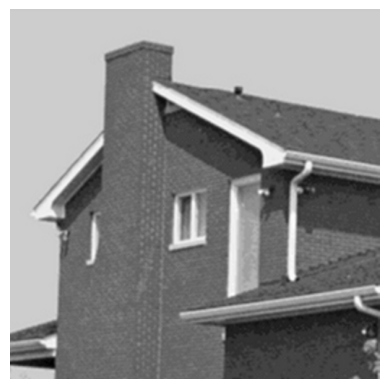

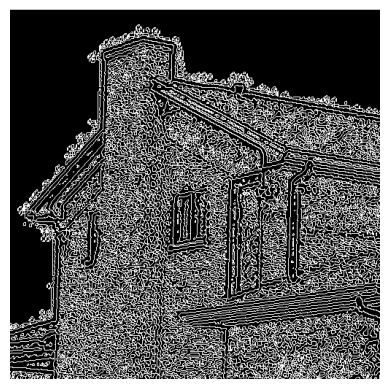

In [28]:
plt.figure()
img = cv2.imread('house.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(_expand_repeat(img))
plt.axis('off')
plt.show()
plt.figure()
plt.imshow(_expand_repeat(edge_detector()))
plt.axis('off')
plt.show()

In [29]:
def _create_accumulator(edge_img, rho_len = 180, theta_len = 180, save_accum=True):
    height, width = edge_img.shape

    # quantize rho params (dividing into sequences)
    rho_range = np.sqrt((height ** 2) + (width ** 2))
    rho_step = 2 * rho_range / rho_len
    rho_ax = np.arange(-rho_range, rho_range, step=rho_step)

    # theta ax
    theta_ax = np.arange(0, theta_len)
    rad_theta_ax = np.deg2rad(theta_ax)

    # init accum
    accum = np.zeros((len(rho_ax), len(rad_theta_ax))) # it should be (180, 180)

    # finding the edge points
    for row in range(height):
        for col in range(width):
            if edge_img[row, col] != 0: # edge
                for idx, theta in enumerate(rad_theta_ax):
                    # calculate rho for given theta
                    sin = np.sin(theta)
                    cos = np.cos(theta)

                    # set center to zero
                    edge_transformed_x = col - (width / 2)
                    edge_transformed_y = row - (height / 2)

                    rho = cos * edge_transformed_x + sin * edge_transformed_y

                    # find the nearest rho idx
                    nearest_rho_idx = np.argmin(np.abs(rho_ax - rho))

                    accum[nearest_rho_idx, idx] = accum[nearest_rho_idx, idx] + 1
    if save_accum:
        with open('accum.npy', 'wb') as fp_accum:
            np.save(fp_accum, accum)

        with open('rho_ax.npy', 'wb') as fp_rho:
            np.save(fp_rho, rho_ax)

        with open('rad_theta_ax.npy', 'wb') as fp_rad_theta:
            np.save(fp_rad_theta, rad_theta_ax)

    return accum, rho_ax, rad_theta_ax

def _extract_lines(edge_img):
    if os.path.exists('accum.npy'):
        with open('accum.npy', 'rb') as fp_accum:
            accum = np.load(fp_accum, allow_pickle=True)

        with open('rho_ax.npy', 'rb') as fp_rho:
            rho_ax = np.load(fp_rho, allow_pickle=True)

        with open('rad_theta_ax.npy', 'rb') as fp_rad_theta:
            rad_theta_ax = np.load(fp_rad_theta, allow_pickle=True)
    else:
        accum, rho_ax, rad_theta_ax = _create_accumulator(edge_img)

    maximum_intersection_lines = 10
    maximum_intersection_arr = np.zeros((maximum_intersection_lines, 2)) # row and col idx

    max_sorted = np.sort(accum, axis=None)[::-1][:maximum_intersection_lines]
    iter_idx = 0
    for max_elem in max_sorted:
        curr_max_arr = np.argwhere(accum==max_elem)
        for curr_max in curr_max_arr:
            maximum_intersection_arr[iter_idx] = curr_max
            iter_idx += 1
            if iter_idx == maximum_intersection_lines:
                break
        if iter_idx == maximum_intersection_lines:
            break
    maximum_intersection_arr = maximum_intersection_arr.astype(int)

    lines = np.zeros((maximum_intersection_lines, 4)) # x1, y1, x2, y2
    for idx in range(maximum_intersection_lines):
        rho = rho_ax[maximum_intersection_arr[idx][0]]
        rad_theta = rad_theta_ax[maximum_intersection_arr[idx][1]]

        if rad_theta != 0:
            x_1, x_2 = 0, edge_img.shape[1]
            y_1 = rho / np.sin(rad_theta)
            y_2 = (rho - x_2 * np.cos(rad_theta)) / np.sin(rad_theta)
            lines[idx] = np.asarray([x_1, y_1, x_2, y_2])
        else:
            if rho > 0:
                x_1, y_1, x_2, y_2 = rho, 0, rho, edge_img.shape[0]
                lines[idx] = np.asarray([x_1, y_1, x_2, y_2])

    return lines

def Hough_transform():
    edge_img = edge_detector()
    img = cv2.imread('house.tif', cv2.IMREAD_GRAYSCALE)

    lines = _extract_lines(edge_img)
    plt.imshow(img)
    for row in lines:
        if row.any():
            plt.plot([row[0], row[2]], [row[1], row[3]])
    plt.show()

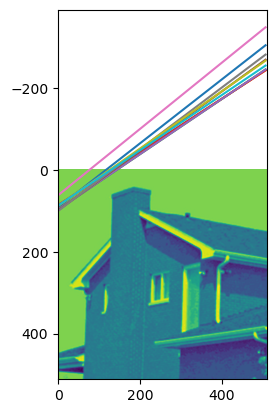

In [30]:
Hough_transform()